In [26]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import xgboost
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline
import os


              precision    recall  f1-score   support

         0.0       1.00      0.88      0.93     29141
         1.0       0.01      0.57      0.02        74

    accuracy                           0.88     29215
   macro avg       0.51      0.72      0.48     29215
weighted avg       1.00      0.88      0.93     29215



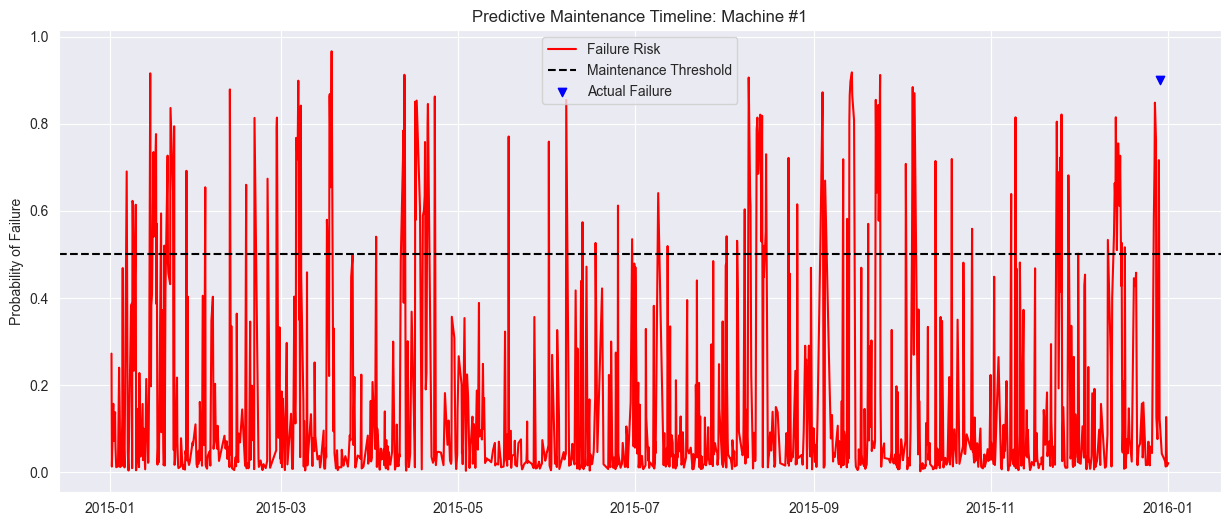

In [27]:
# 1. Load Data
telemetry = pd.read_csv('PdM_telemetry.csv', parse_dates=['datetime'])
failures = pd.read_csv('PdM_failures.csv', parse_dates=['datetime'])

# 2. Resample to 3-Hour Windows (Crucial for Speed)
# We calculate Mean and Std Dev to capture sensor stability
fields = ['volt', 'rotate', 'pressure', 'vibration']
telemetry_mean = telemetry.groupby('machineID').resample('3h', on='datetime')[fields].mean().reset_index()
telemetry_std = telemetry.groupby('machineID').resample('3h', on='datetime')[fields].std().reset_index()

# Rename and Merge
telemetry_mean.columns = [c + '_mean' if c in fields else c for c in telemetry_mean.columns]
telemetry_std.columns = [c + '_std' if c in fields else c for c in telemetry_std.columns]
df = pd.merge(telemetry_mean, telemetry_std, on=['datetime', 'machineID'])

# 3. Create the Target (Failure in the next 24 hours)
# Shift labels back by 8 windows (8 * 3H = 24H)
failures['failure_event'] = 1
df = pd.merge(df, failures[['datetime', 'machineID', 'failure_event']], on=['datetime', 'machineID'], how='left')
df['target'] = df.groupby('machineID')['failure_event'].shift(-8).fillna(0)

# 4. Prepare for XGBoost
feature_cols = [c for c in df.columns if '_mean' in c or '_std' in c]
X = df[feature_cols].fillna(0)
y = df['target']

# Calculate class weight ratio (XGBoost uses this to prioritize rare failures)
ratio = (y == 0).sum() / (y == 1).sum()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)

# 5. Initialize and Train XGBoost
model_xgb = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    tree_method='hist',           # Use 'hist' for massive speed boost
    scale_pos_weight=ratio,      # Handles imbalanced failure data
    eval_metric='logloss',
)

model_xgb.fit(X_train, y_train)

# 6. Results
y_pred = model_xgb.predict(X_test)
print(classification_report(y_test, y_pred))

# We filter the 'test_df' because the model hasn't seen this data yet
train_df, test_df = train_test_split(df, test_size=0.4, stratify=df['target'])
m1_test = test_df[test_df['machineID'] == 2].sort_values('datetime')
m1_features = m1_test[feature_cols].fillna(0)

# 4. Predict Probabilities (0.0 to 1.0)
# We use predict_proba instead of predict to get the "risk level"
m1_probs = model_xgb.predict_proba(m1_features)[:, 1]

# 5. Plot the Timeline
plt.figure(figsize=(15, 6))
plt.plot(m1_test['datetime'], m1_probs, color='red', label='Failure Risk')
plt.axhline(y=0.5, color='black', linestyle='--', label='Maintenance Threshold')

# Overlay actual failure events
actual_failures = m1_test[m1_test['failure_event'] == 1]
plt.scatter(actual_failures['datetime'], [0.9]*len(actual_failures), color='blue', marker='v', label='Actual Failure')

plt.title('Predictive Maintenance Timeline: Machine #1')
plt.ylabel('Probability of Failure')
plt.legend()
plt.show()